In [910]:
# import os; os.environ['CUDA_VISIBLE_DEVICES'] = ""

In [911]:
import tensorflow as tf; tf.test.is_gpu_available()

2024-04-22 11:38:40.027870: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 4115 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:65:00.0, compute capability: 7.5


True

In [912]:
tf.__version__

'2.8.0'

In [913]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"TensorFlow is using GPU: {physical_devices[0]}")
else:
    print("No GPU devices found. TensorFlow will run on CPU.")

TensorFlow is using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [914]:
# from google.colab import drive
# drive.mount('/content/drive')

In [915]:
## importing required packages
import numpy as np
from os import listdir
import tensorflow as tf
import keras
from  keras import layers
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

In [916]:
## CONFIGURATION 
EPOCHS = 5
BUFFER_SIZE = 2000
BATCH_SIZE = 1

IMG_HEIGHT = 128
IMG_WIDTH = 128

In [917]:
# image_dir = "/content/drive/My Drive/3d printer/codes/datasets/cropped-datasets/"
# masks_dir = "/content/drive/My Drive/3d printer/codes/datasets/ground-truth/"

image_dir = "./All_images/"
masks_dir = "./All_masks/"

In [918]:
# import glob
# img_files = glob.glob(image_dir + '/**/*.jpg', recursive=True)
# mask_files = glob.glob(masks_dir + '/**/*.png', recursive=True)
# img_files[:10], mask_files[:10]

In [919]:
# choose on of the pairs of data and mask for dataset

# img_folders = ['abyek_images', 'Khorasan_part1_images', 'bound_images', 'France_images']
# mask_folders = ['abyek_masks', 'Khorasan_part1_masks', 'bound_masks', 'France_masks']

img_folders = ['abyek_images', 'Khorasan_part1_images',  'deliniation_images', 'bound_images']
mask_folders = ['abyek_masks', 'Khorasan_part1_masks', 'deliniation_masks', 'bound_masks']

# img_folders = ['abyek_images']
# mask_folders = ['abyek_masks']


images_path, masks_path = [], []
# loop in pair of data and mask to make list of images and masks based on folder image
for fol, mfol in zip(img_folders, mask_folders):
    images_list = listdir(image_dir + fol)
    masks_list = listdir(masks_dir + mfol)

    img_list = [i.split('.jpg')[0] for i in images_list]
    msk_list = [i.split('.png')[0] for i in masks_list]

    commons = list(set(img_list) & set(msk_list))

    # shuffle(commons)
    
    print(len(commons))
    
    # commons = commons[:1200]

    ip =  [image_dir + fol + "/" + i + ".jpg"  for i in commons]
    mp  = [masks_dir + mfol + "/" + i + ".png"  for i in commons]
    # print(len(ip), len(mp))

    images_path.extend(ip)
    masks_path.extend(mp)
    # print(len(images_path), len(masks_path))

1155
1001
1966
1200


In [920]:
images_path[:10], masks_path[:10] 

(['./All_images/abyek_images/712.jpg',
  './All_images/abyek_images/1003.jpg',
  './All_images/abyek_images/1300.jpg',
  './All_images/abyek_images/1591.jpg',
  './All_images/abyek_images/364.jpg',
  './All_images/abyek_images/1214.jpg',
  './All_images/abyek_images/111.jpg',
  './All_images/abyek_images/510.jpg',
  './All_images/abyek_images/205.jpg',
  './All_images/abyek_images/890.jpg'],
 ['./All_masks/abyek_masks/712.png',
  './All_masks/abyek_masks/1003.png',
  './All_masks/abyek_masks/1300.png',
  './All_masks/abyek_masks/1591.png',
  './All_masks/abyek_masks/364.png',
  './All_masks/abyek_masks/1214.png',
  './All_masks/abyek_masks/111.png',
  './All_masks/abyek_masks/510.png',
  './All_masks/abyek_masks/205.png',
  './All_masks/abyek_masks/890.png'])

In [921]:
def load_images(image_path, mask_path, img_size = (IMG_HEIGHT, IMG_WIDTH)):
  # load our images from the image and mask path
  img_data = tf.io.read_file(image_path)
  img = tf.io.decode_png(img_data,channels=3)
  img = tf.image.convert_image_dtype(img,tf.float32)

  segm_data = tf.io.read_file(mask_path)
  mask = tf.io.decode_png(segm_data)
  mask = tf.math.reduce_max(mask, axis = -1, keepdims=True)
  mask = mask / 255

  img = tf.image.resize(img, img_size , method = 'nearest')
  mask = tf.image.resize(mask, img_size, method = 'nearest')
  
  return img, mask

In [922]:
# make tensorflow dataset with given buffer size to fetch data in RAM based on buffer size 
dataset = tf.data.Dataset.from_tensor_slices((images_path, masks_path))
dataset = dataset.map(load_images ,num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE).shuffle(BUFFER_SIZE)

In [923]:
def compute_sample_weights(image, mask):
	''' Compute sample weights for the image given class. '''
	# Compute relative weight of class
	class_weights = tf.constant([2., 8.0])
	class_weights = class_weights/tf.reduce_sum(class_weights)

  	# Compute same-shaped Tensor as mask with sample weights per
  	# mask element. 
	sample_weights = tf.gather(class_weights,indices=\
  	tf.cast(mask, tf.int32))

	return image, mask, sample_weights

In [924]:
seed = 123
# divide our dataset into training and test set
val_dataset = (dataset
               .take(300)
               .prefetch(buffer_size=tf.data.AUTOTUNE) 
               )
train_dataset = (dataset
                .skip(300)
                # .map(lambda image, mask: (tf.image.random_flip_up_down(image, seed=seed), tf.image.random_flip_up_down(mask, seed=seed)))
                # .map(lambda image, label: (tf.image.random_flip_left_right(image, seed=seed), tf.image.random_flip_left_right(label, seed=seed)))
                # .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=0.8), label))
                .map(compute_sample_weights)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
                # .repeat(2)
                ) 
# train_dataset = train_dataset.map(lambda image, mask: (tf.image.random_flip_up_down(image, seed=seed), tf.image.random_flip_up_down(mask, seed=seed))).repeat(1)

In [925]:
train_dataset.cardinality().numpy()

5022

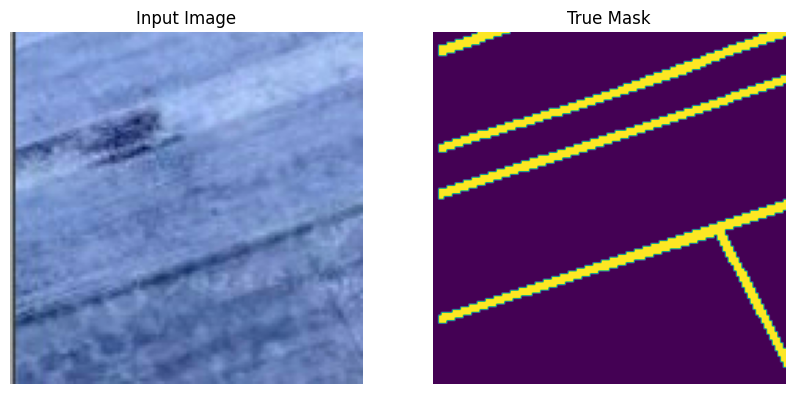

In [926]:
# plot images
def display(display_list, num_plot, flag=False):
  plt.figure(figsize=(10,10))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  if flag:
    plt.savefig(f"./Result_plots/result_img_{num_plot}.png")
    
N = 1
for image,mask in dataset.take(N):
  sample_image, sample_mask = image[0],mask[0]
  display([sample_image,sample_mask], False)
  

## Unet Model


In [927]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.)(p)

   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [928]:
def build_unet_model():
   # inputs
   inputs = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
   l1 = 4
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, l1*2)
   # 2 - downsample
   f2, p2 = downsample_block(p1, l1*4)
   # 3 - downsample
   f3, p3 = downsample_block(p2, l1*8)
   # 4 - downsample
   f4, p4 = downsample_block(p3,l1*16)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, l1*32)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, l1*16)
   # 7 - upsample
   u7 = upsample_block(u6, f3, l1*8)
   # 8 - upsample
   u8 = upsample_block(u7, f2, l1*4)
   # 9 - upsample
   u9 = upsample_block(u8, f1, l1*2)

   # outputs
   outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [929]:
# build the model
model = build_unet_model()

In [930]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_608 (Conv2D)            (None, 128, 128, 8)  224         ['input_33[0][0]']               
                                                                                                  
 conv2d_609 (Conv2D)            (None, 128, 128, 8)  584         ['conv2d_608[0][0]']             
                                                                                                  
 max_pooling2d_128 (MaxPooling2  (None, 64, 64, 8)   0           ['conv2d_609[0][0]']         

In [931]:
from tensorflow.keras.optimizers import Adam
import keras.backend as K

# calculate iou metric
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])

# compile the model 
model.compile(
     optimizer=Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        # loss="mse",
        # loss = weightedLoss(keras.losses.binary_crossentropy, [1.0, 50.0]),
        metrics=["accuracy", "Precision", iou],
        # sample_weight_mode="temporal",
  )

In [932]:
# make checkpoint to save model in each epoch
callbacks = [
    # ReduceLROnPlateau(patience=3, verbose=1),
    # EarlyStopping(patience=12, verbose=1),
    ModelCheckpoint('unet-model.h5', verbose=0, save_freq="epoch", save_best_only=True,save_weights_only=False)
    ]

In [933]:
# fiting the model
history = model.fit(
      train_dataset,
      epochs=EPOCHS,
      validation_data = val_dataset,
      # validation_steps = 8,
      # batch_size=BATCH_SIZE,
      callbacks = callbacks,
      # class_weight=class_weights,
      # sample_weight = [1.0, 2.0], 
    )

Epoch 1/5


5022/5022 [==============================] - 51s 10ms/step - loss: 0.1540 - accuracy: 0.7956 - precision: 0.3334 - io_u_51: 0.8664 - val_loss: 0.4507 - val_accuracy: 0.7951 - val_precision: 0.1962 - val_io_u_51: 0.9283
Epoch 2/5
1242/5022 [======>.......................] - ETA: 35s - loss: 0.1350 - accuracy: 0.8122 - precision: 0.3568 - io_u_51: 0.8750

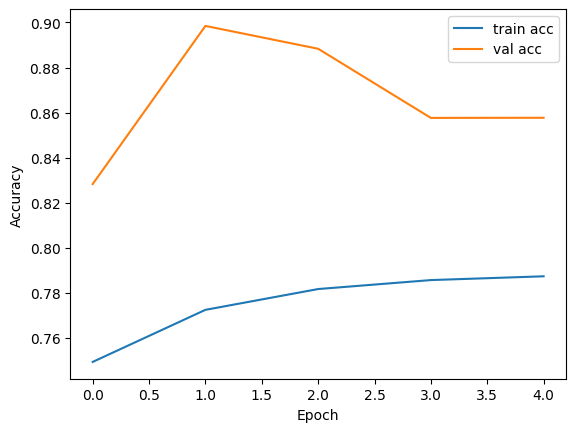

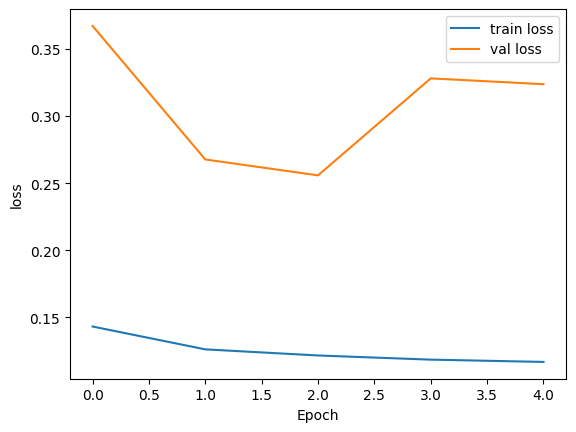

In [ ]:
# plot the accuracy and loss plots for train and test data

plt.plot(history.history["accuracy"], label='train acc')
plt.plot(history.history["val_accuracy"], label='val acc')
# plt.ylim([0.93, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history["loss"], label='train loss')
plt.plot(history.history["val_loss"], label='val loss')
# plt.ylim([0.93, 1])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# plot accuracy, precision and IOU  

# fig , ax = plt.subplots(1, 3, figsize=(13, 4))

# ax[0].plot(history.history["accuracy"], label='train acc')
# ax[0].plot(history.history["val_accuracy"], label='val acc')
# ax[0].set_title('Accuracy')
# ax[0].legend()

# ax[1].plot(history.history["precision"], label='train pr')
# ax[1].plot(history.history["val_precision"], label='val pr')
# ax[1].set_title('Precision')
# ax[1].legend()

# ax[2].plot(history.history["io_u_10"], label='train iou')
# ax[2].plot(history.history["val_io_u_10"], label='val iou')
# ax[2].set_title('IOU')
# ax[2].legend()

# plt.show()

In [ ]:
# create mask from predicted mask 
def create_mask(pred_mask):
    # pred_mask = tf.argmax(pred_mask, axis=-1)
    pred = pred_mask[0]
    # threshold of 0.5 to differ labels from predicted mask
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0
    # pred_mask = pred_mask[..., tf.newaxis]
    return pred

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        counter = 0
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image, verbose=0)
            # print(pred_mask[0][pred_mask[0]>0.5])
            display([image[0], mask[0], create_mask(pred_mask)], counter, True)
            counter += 1
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

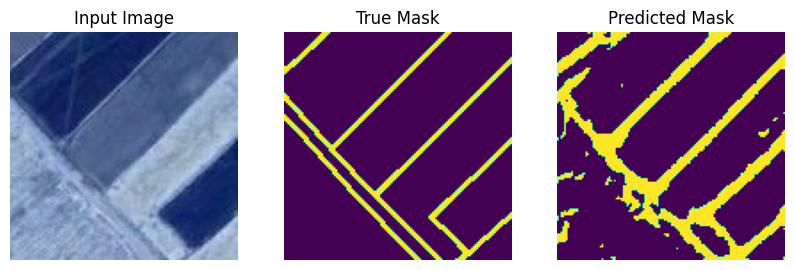

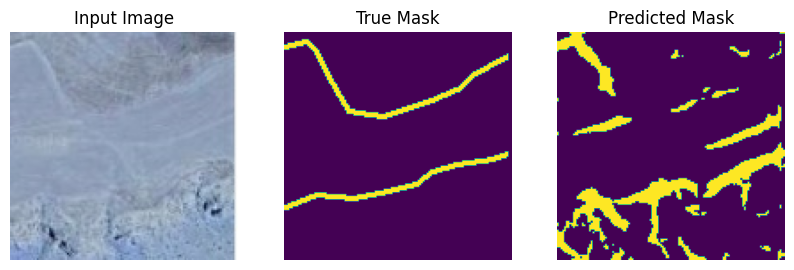

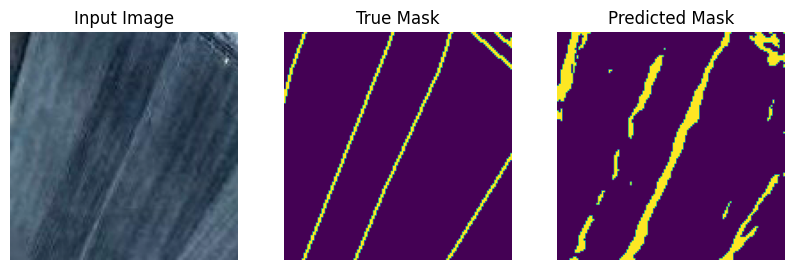

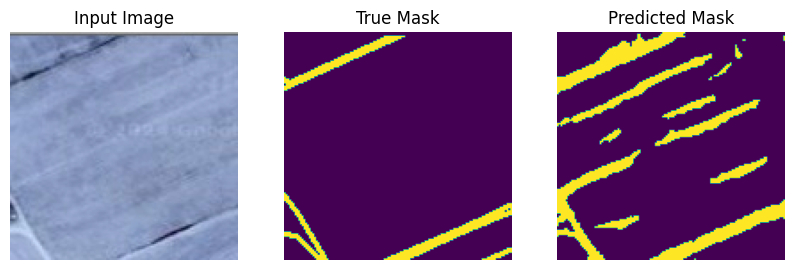

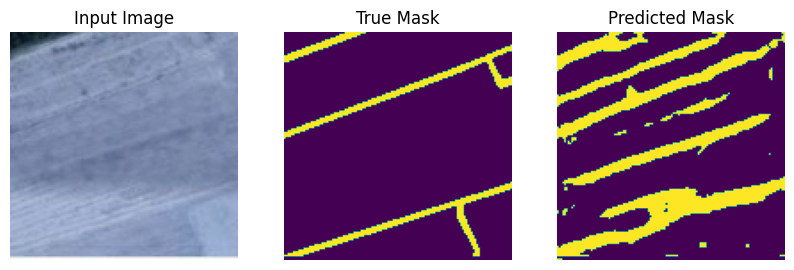

In [ ]:
## displaying our result
show_predictions(val_dataset,num=5)